In [128]:
try:
     import dlroms.fespaces as fe
except:
     !pip install --no-deps git+https://github.com/NicolaRFranco/dlroms.git
     import dlroms.fespaces as fe

import numpy as np
import matplotlib.pyplot as plt
from dlroms import clc
import scipy

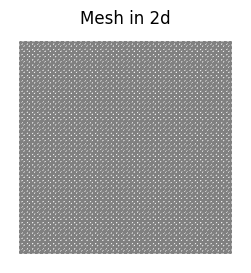

In [129]:
h = 40
mesh = fe.unitsquaremesh(h, h)
plt.figure(figsize = (4, 3))
fe.plot(mesh)
plt.title("Mesh in 2d")
None

In [130]:
Vh = fe.space(mesh, 'CG', 1)
clc()

In [131]:
mesh.ufl_cell()

triangle

In [132]:
def assembleM(Vh):
  from fenics import assemble, dx, TrialFunction, TestFunction
  u, v = TrialFunction(Vh), TestFunction(Vh) # symbols
  M = assemble(u*v*dx).array()               # bilinear form is assembled and converted to array
  clc()
  return M

def assembleK(k, Vh):
  import inspect
  if(len(inspect.signature(k).parameters)!=1):
    raise RuntimeError("This function accepts isotropic kernels only (k should be a function of a single argument).")

  vertices = fe.dofs(Vh)             # Nh x d array listing all vertices
  dim = vertices.shape[1]              # spatial dimension

  # Constructing the matrix C with Cij = k(|x_i-x_j|)
  d = np.linalg.norm(vertices.reshape(-1, 1, dim) - vertices.reshape(1, -1, dim), axis = -1)
  C = k(d)

  # Adjusting to include quadrature rules (K is an integral operator!)
  M = assembleM(Vh)
  K = C @ M
  return K

def KKLdecomposition(kernel, mesh):
  from scipy.linalg import eigh
  K = assembleK(kernel, mesh)
  M = assembleM(mesh)

  lambdas, psis = eigh(M @ K, M)      # solving eigenvalue problem with M-orthogonality
  lambdas = np.flip(lambdas)          # re-sorting in descending order
  psis = np.flip(psis, axis = -1)     # same

  nmax = sum(lambdas>0)               # negative values may appear due to floating point errors
  lambdas = lambdas[:nmax]
  psis = psis[:, :nmax]
  return lambdas, psis, M

def KKLcombine(xis, lambdas_kkl, psis_kkl):
  coefficients = np.sqrt(lambdas_kkl.reshape(-1,1)) * xis
  Z = psis_kkl @ coefficients
  return Z

# a)

In [133]:
N = 1000

kernel = lambda r: np.exp(-15*r**2)
lambdas, psis, M = KKLdecomposition(kernel, Vh)

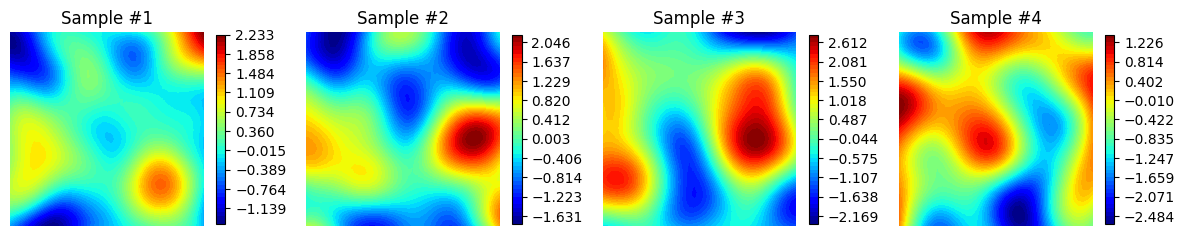

In [134]:
# np.random.seed(1)
xis = np.random.randn(psis.shape[1], N)
Z = KKLcombine(xis, lambdas, psis)

plt.figure(figsize = (12, 3))
for i in range(4):
  plt.subplot(1,4,i+1)
  fe.plot(Z[:, i], Vh, levels = 50, colorbar = True, shrink = 0.7)
  plt.title("Sample #%d" % (i+1))

plt.tight_layout()

In [135]:
G_inf = np.max(np.abs(Z), axis = 0)
G_est = float(np.mean(G_inf))
print("Estimated G_inf mean: %.4f" % G_est)

Estimated G_inf mean: 2.4948


# b)

In [136]:
G_var = G_inf.var(ddof = 1)
alpha = 0.01
z = scipy.stats.norm.ppf(1.0-alpha)
conf_int = (-np.inf, G_est + z*np.sqrt(G_var/N))
print("99%% unilateral confidence interval for G_inf mean: (%.4f, %.4f)" % conf_int)

99% unilateral confidence interval for G_inf mean: (-inf, 2.5322)


In [137]:
np.sqrt(2*np.pi)

np.float64(2.5066282746310002)

# TODO: complete the justification of the answer

# c)